In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore', category=FutureWarning)

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data'
sdata = read_zarr( os.path.join(  OUTPUT_DIR, 'sdata.zarr'  ) )
anndata = sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/anndataNucA11') # reset original anndata
# delete anndata
del sdata.table
# create anndata
sdata.table = anndata
sdata

SpatialData object with:
├── Images
│     ├── 'clahe': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'raw_image': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tiling_correction': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tophat_filtered': SpatialImage[cyx] (1, 12864, 10720)
│     └── 'transcript_density': SpatialImage[cyx] (1, 12864, 10720)
├── Labels
│     └── 'segmentation_mask': SpatialImage[yx] (12864, 10720)
├── Points
│     └── 'transcripts': DataFrame with shape: (4754932, 3) (2D points)
├── Shapes
│     ├── 'expanded_cells20': GeoDataFrame shape: (11228, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_segmentation': GeoDataFrame shape: (50, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_size': GeoDataFrame shape: (280, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_boundaries_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_

In [3]:
make_umap_and_perform_leiden_annotation(sdata,17,35,0.8)


/home/wout/mambaforge/envs/napari-sparrow/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wout/mambaforge/envs/napari-sparrow/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wout/mambaforge/envs/napari-sparrow/lib/python3.10

/home/wout/mambaforge/envs/napari-sparrow/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


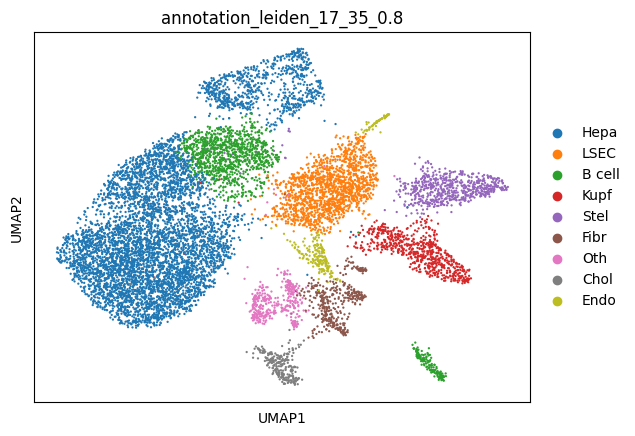

Hepa      0.526986
LSEC      0.134841
B cell    0.106608
Kupf      0.059049
Stel      0.057357
Fibr      0.036694
Oth       0.034378
Endo      0.022177
Chol      0.021910
Name: annotation_leiden_17_35_0.8, dtype: float64
categories: Hepa, LSEC, B cell, etc.
var_group_labels: hepa, hepa_chol_stel_fibr_oth, hepa, etc.


/home/wout/mambaforge/envs/napari-sparrow/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


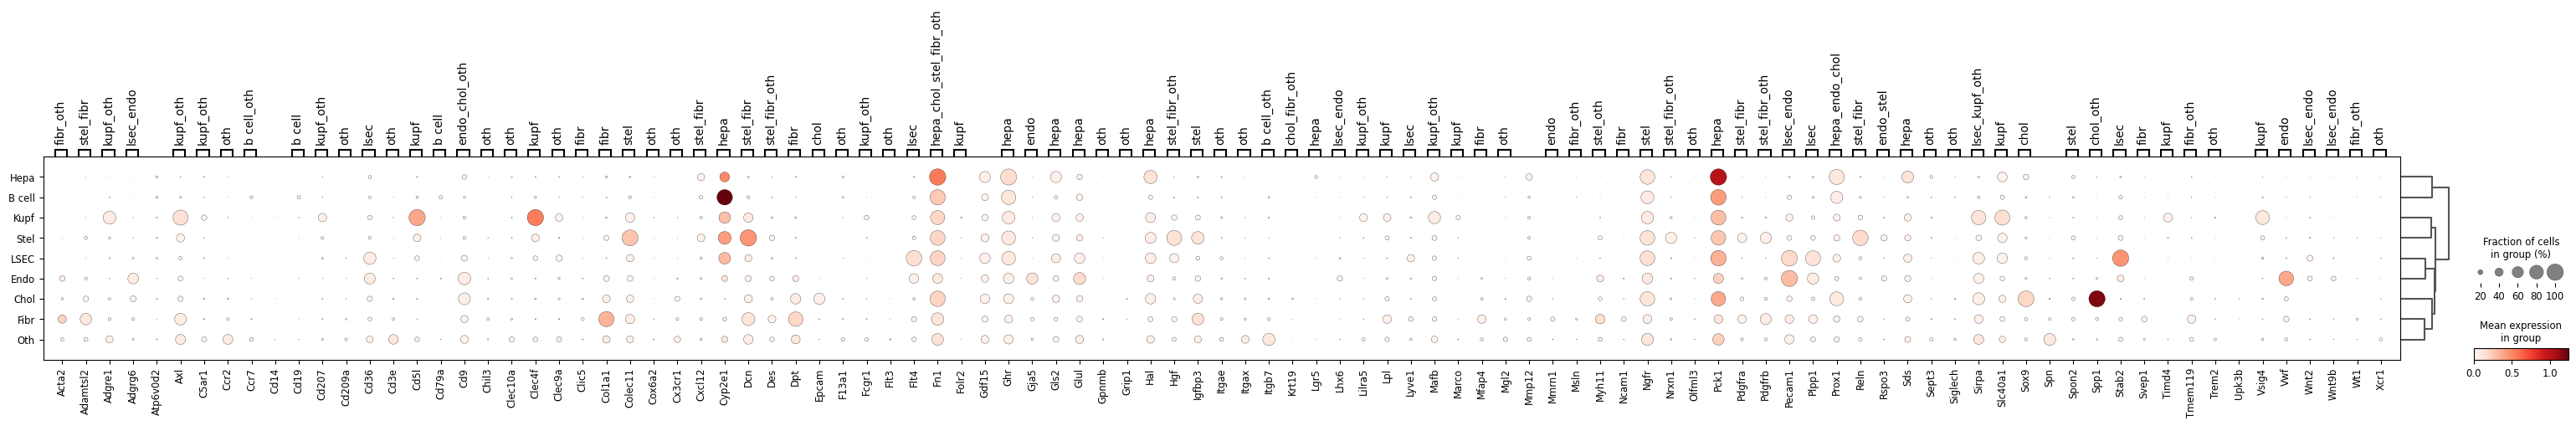

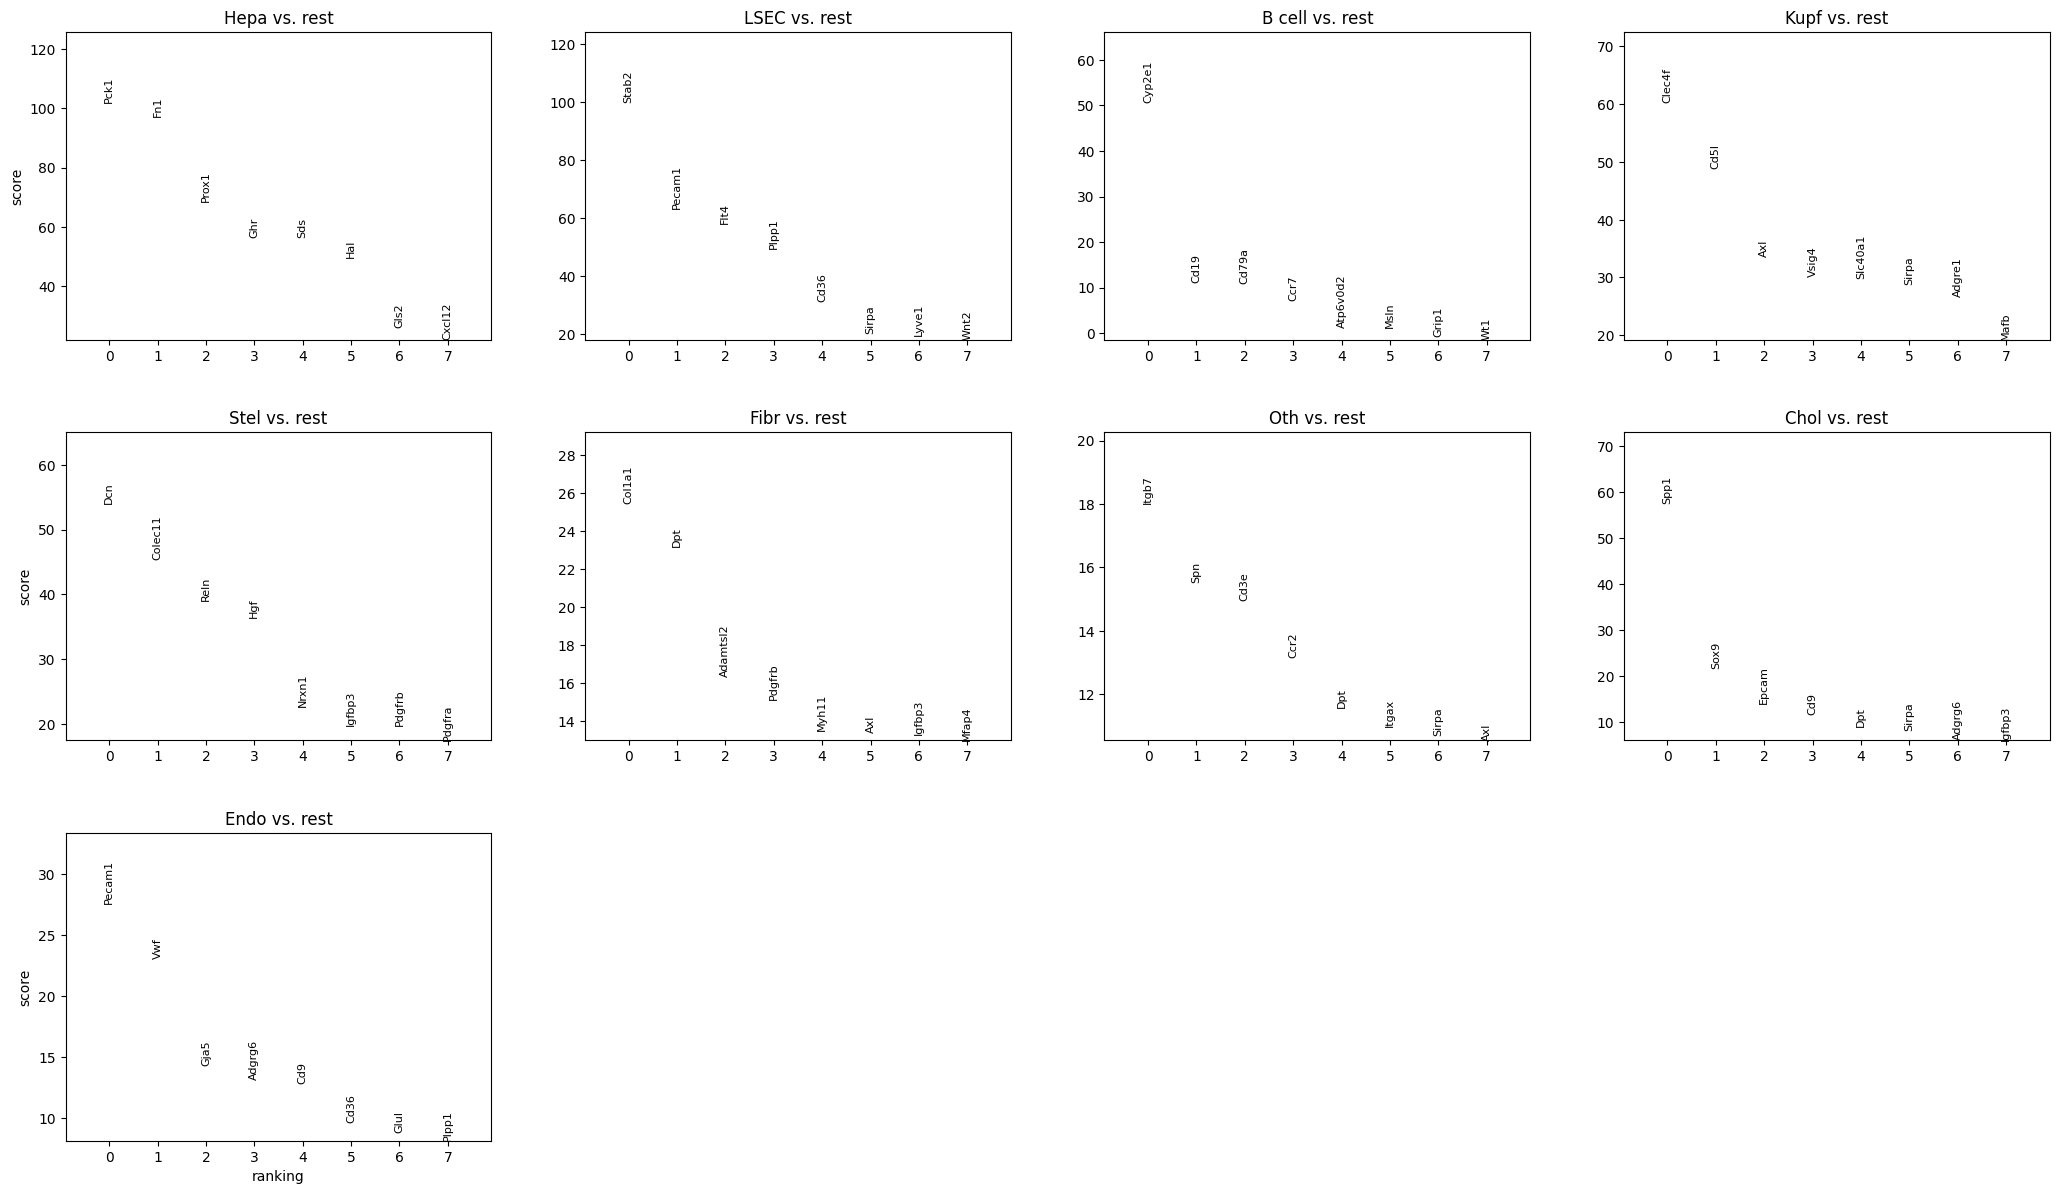

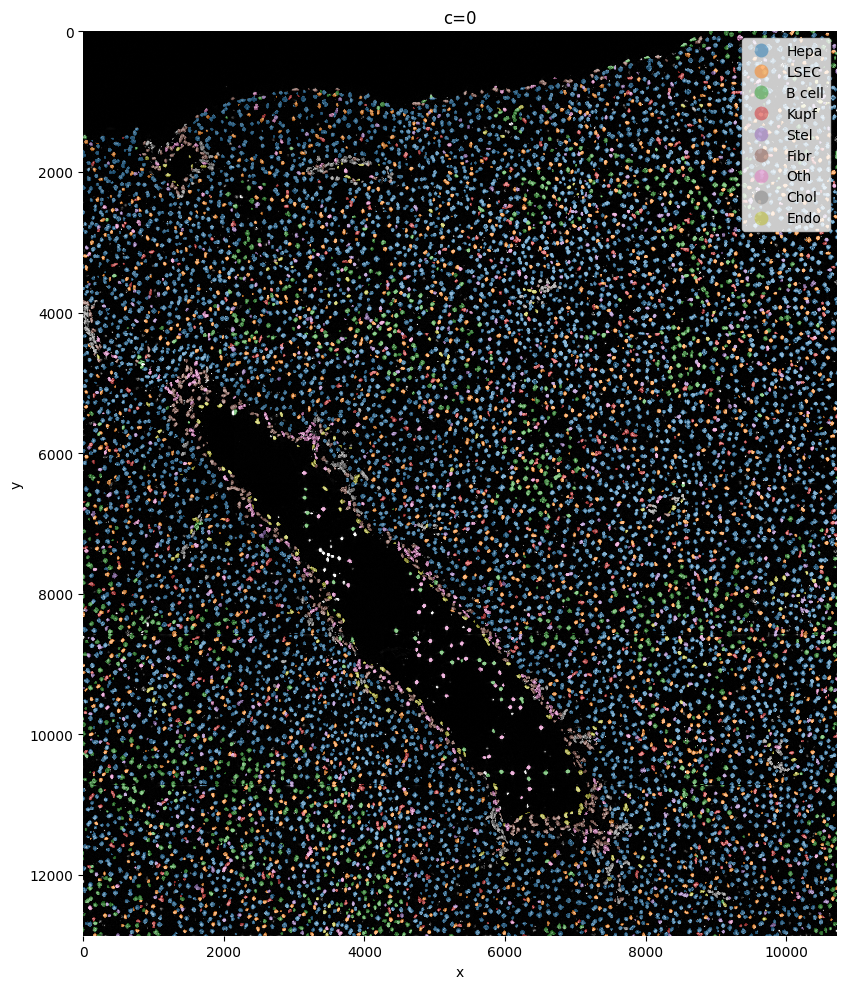

In [5]:
visualize_classification(sdata,'annotation_leiden_17_35_0.8','umap_17_35')

In [ ]:
sdata

SpatialData object with:
├── Images
│     ├── 'clahe': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'raw_image': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tiling_correction': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tophat_filtered': SpatialImage[cyx] (1, 12864, 10720)
│     └── 'transcript_density': SpatialImage[cyx] (1, 12864, 10720)
├── Labels
│     └── 'segmentation_mask': SpatialImage[yx] (12864, 10720)
├── Points
│     └── 'transcripts': DataFrame with shape: (4754932, 3) (2D points)
├── Shapes
│     ├── 'expanded_cells20': GeoDataFrame shape: (11228, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_segmentation': GeoDataFrame shape: (50, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_size': GeoDataFrame shape: (280, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_boundaries_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_